# 2.  Camera Calibration


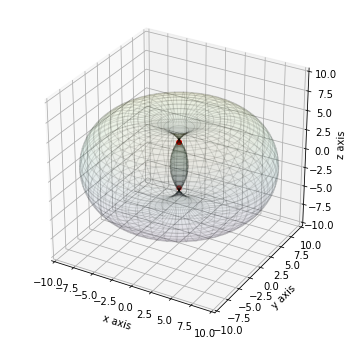

In [1]:
%matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

u=np.linspace(0,2*np.pi,100)
v=np.linspace(0,2*np.pi,100)
u,v=np.meshgrid(u,v)
a = 6
b = 5
X = (b + a*np.cos(u)) * np.cos(v)
Y = (b + a*np.cos(u)) * np.sin(v)
Z = a * np.sin(u)

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
#ax.set_aspect('equal')

ax.scatter([0,0], [0,0], [-3,3], c='r', marker='o')
ax.plot_surface(X, Y, Z,alpha=0.05, cmap='viridis', edgecolor='black')
ax.scatter([0,0], [0,0], [-3,3], c='r', marker='o')

plt.show()

### Implementing DLT

In the following we will show how you can implement the DLT algorithm to estimate the pose of the camera from a set of given 2D-3D correspondences.

We start of with writing a method that produces the matrix M of the DLT algorithm

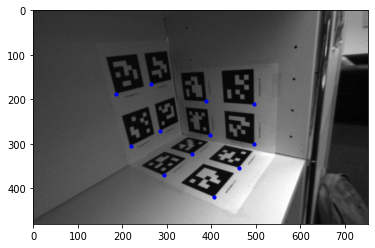

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Cameras intrinsic parameters [K] (f~420px, w~710px, h~500px)
K = np.array(
    [[420.506712, 0.,          355.208298],
     [0.,         420.610940,  250.336787],
     [0.,         0.,          1.]]
)

# (n = 12) reference 3D points, in the world coordinate, in centimeters
world_corners = 0.01* np.array(
    [[19.4, 9.0,   19.4, 9.0,     19.4,   9.0,     19.4,   9.0,   0.0,   0.0,   0.0,   0.0], #Y
     [0.,   0.,   0.,   0., 10.95, 10.95, 24.45, 24.45, 10.95, 24.45, 10.95, 24.45], #X
     [18.6,   18.6, 5.1, 5.1,   0.0,   0.0,   0.0,   0.0,   12.0,   12.0,    1.6,    1.6]] #Z
)

detected_corners = np.array(
    [[186.5, 264.5, 218.5, 285.5, 292.5, 356.5, 406.5, 461.5, 388.5, 495.5, 396.5, 496.5],
     [187.5, 166.5, 304.5, 270.5, 369.5, 322.5, 418.5, 353.5, 204.5, 211.5, 280.5, 300.5]]
)


# Example image (since we have a greyscale image, reduce dimensionality down to 2)
img = mpimg.imread('image/Camera-Calibration/img_0001.jpg')[:,:,0]
plt.imshow(img, cmap='gray')
plt.scatter(x=detected_corners[0], y=detected_corners[1], c='b', s=10)

plt.show()



In [9]:
def DLTPoseEstimation(image_points, world_points, K):
    """
    Estimate the pose of the camera from the given 2D-3D correspondences 
    and the given camera intrinsics.
    :param np.ndarray[float, float] image_points:      vector of undistorted image coordinates
    :param np.ndarray[float, float] world_points:    vector of world coordinates
    :param np.ndarray[float, float] K:               camera matrix, intrinsics
    :return: projection matrix M [R|t] with R (Rotation matrix) t (translation)
    :rtype: np.array(...)
    """
    # convert 2D points to 3D points by adding 1 to the third dimension
    image_3d = np.concatenate((image_points, np.ones((1,len(image_points[0])))), axis=0)
    
    # normalize the coordinates by applying the camera intrinsics
    image_points_normalized = np.linalg.solve(K, image_3d)
                               
    # create Q matrix to fill, initialize with zeros
    Q = np.zeros((2*len(image_points_normalized[0]), 12))
        
    # fill the Q-amtrix according to its definition
    for i in range(len(image_points_normalized[0])):
        u = image_points_normalized[0,i]
        v = image_points_normalized[1,i]
        
        Q[2*i,:3] = world_points[:,i]
        Q[2*i,3] = 1
        Q[2*i,8:11] = -u*world_points[:,i] 
        Q[2*i,11] = -u    
                               
        Q[2*i+1,4:7] = world_points[:,i]
        Q[2*i+1,7] = 1
        Q[2*i+1,8:11] = -v*world_points[:,i] 
        Q[2*i+1,11] = -v
           
    # solve the system Q*M = 0 for M
    u_of_M, s_of_M, vh_of_M = np.linalg.svd(Q)
    # reshape the vector to be 3x4 for the projection matrix M
    M = np.array(vh_of_M[-1,:]).reshape((3, 4))

    # extract the rotation matrix R
    R = M[:,0:3]
    # ensure that the determinant of R is positive. if not multiply M (and R) with -1
    if (np.linalg.det(R)) < 0:
        M = -M
        R = -R
            
    
    # We have to make sure the R is a real rotation matrix so that all eigenvalues are 1
    # so achieve this we use the SVD (R=USV) and multiply the solution together 
    # but with the identity matrix instead of S (R_tilde=UV)
    # TODO use QR
    u_of_R, s_of_R, vh_of_R = np.linalg.svd(R)
    R_tilde = np.matmul(u_of_R,vh_of_R)

    # what we have so far is a projection matrix without the correct scaling factor
    # we can get the scaling alpha by deviding the norm of R_tilde ba the norm of R
    alpha = np.linalg.norm(R_tilde)/np.linalg.norm(R)

    # Now we can put together the final M_tilde=[R_tilde|alpha*t]
    M_tilde = np.concatenate((R_tilde, alpha*M[:,3].reshape(3,1)), axis=1)
    return M_tilde

def worldToPixels(world_points, M, K):
    """
    Convers a vector in world coordinates to uv pixel coordinates (Reprojection)
    :param np.array(x, y, z, 1) Pw:     World vector 
    :return: (u,v) pixel coordinates of world point in image frame
    :rtype: Tuple[number, number]
    """
    world_points_4d = np.concatenate((world_points, np.ones((1,len(world_points[0])))), axis=0)

    Pc = np.matmul(M, world_points_4d)
    Pc_norml = (Pc / Pc[2])
    p = np.matmul(K, Pc_norml)
    uv = p[:-1]
    return uv[0], uv[1]



Now that we have constructed a method for the DLT algorith we can verify wether it works as expected or not. For this we reproject the cornerpoints for with we have the world coordinates onto the image and check if they are correcly positioned on the image.

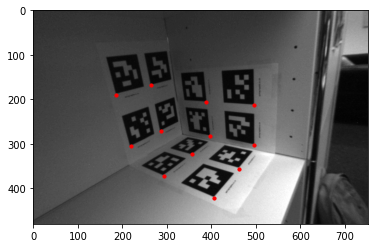

In [10]:
# get the projection matrix
M_dlt = DLTPoseEstimation(detected_corners, world_corners, K);
# reproject the world point onto the image
reprojected_points = worldToPixels(world_corners, M_dlt, K)

# load the image in gray-scale and plot the reprojected points onto it.
img = mpimg.imread('image/Camera-Calibration/img_0001.jpg')[:,:,0]
plt.imshow(img, cmap='gray')
plt.scatter(x=reprojected_points[0], y=reprojected_points[1], c='r', s=10)
plt.show()

We see that our reprojected 3D point are positioned reasonably well.

### Recover camera position

animation showing the 3D position of the camera in each frame. As input we have the detected corners on the image plane for each frame as well as the world coordinates of those corner like before. The input is formatted like in the above example.

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# load the detected corners for each frame, the data is saved as a pickle.
with open('image/Camera-Calibration/detected_corners_vector.pkl', 'rb') as f:
#     detected_corners_all = pickle.load(f)

# create base plot    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=90)
ax.set_xlim(0,0.5)
ax.set_ylim(0,0.5)
ax.set_zlim(0,0.5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# plot the world coordinates of the corners
ax.scatter(world_to_true[0], world_to_true[1], world_to_true[2], c='r', cmap='Greens');

# create plot object which should be animated
graph, = ax.plot([],[],[], c='b', marker='o')
x_line, = ax.plot( [0,0], [0,0], [0,0], c='lime')
y_line, = ax.plot( [0,0], [0,0], [0,0], c='red')
z_line, = ax.plot( [0,0], [0,0], [0,0], c='blue')

# define the lines to represent the camera rotation
x_line_coords = [[0.05],[0],[0]]
y_line_coords = [[0],[0.05],[0]]
z_line_coords = [[0],[0],[0.05]]

def animate(i):
    # get the projection matrics using DLT
    detected_corner_in_frame = detected_corners_all[i]
    M = DLTPoseEstimation(detected_corner_in_frame, world_corners, K);
    
    # extract the rotation matrix and transpose it since we want to inverse the process
    # we also have to multiply with -1 since its determinant would not be 1 
    # otherwise and therefore it would not be a rotation matrix
    rot = -M[:,:3].transpose()
    # apply the rotation to the transplation part of M to recover the camera position
    pos = np.matmul(rot,M[:,3])

    # apply the same rotation to the line wused to represent the camera orientation
    x_line_rot = np.matmul(rot,x_line_coords)[:,0]
    y_line_rot = np.matmul(rot,y_line_coords)[:,0]
    z_line_rot = np.matmul(rot,z_line_coords)[:,0]

    # set the data for the animation
    graph.set_data(pos[0], pos[1])
    graph.set_3d_properties(pos[2])
    x_line.set_data([pos[0], pos[0]+x_line_rot[0]], [pos[1], pos[1]+x_line_rot[1]])
    x_line.set_3d_properties([pos[2], pos[2]+x_line_rot[2]])
    y_line.set_data([pos[0], pos[0]+y_line_rot[0]], [pos[1], pos[1]+y_line_rot[1]])
    y_line.set_3d_properties([pos[2], pos[2]+y_line_rot[2]])
    z_line.set_data([pos[0], pos[0]+z_line_rot[0]], [pos[1], pos[1]+z_line_rot[1]])
    z_line.set_3d_properties([pos[2], pos[2]+z_line_rot[2]])

# run and save animation
anim = FuncAnimation(fig, animate, frames=int(len(detected_corners_all)), interval=20)
anim.save('image/Camera-Calibration/ani.gif', writer='imagemagick')

IndentationError: expected an indented block (<ipython-input-11-1f8b7327afcc>, line 10)

![camera](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/camera.gif)

![ani](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_4/ani.gif)

In [14]:
"""
detected_corners = np.loadtxt('image/chapter_4/detected_corners.txt')
print(detected_corners)
corners = []
for i in range(len(detected_corners)):
    corners.append(np.array((detected_corners[i][::2],detected_corners[i][1::2])))
print(corners)
with open('image/Camera-Calibration/detected_corners_vector.pkl', 'wb') as f:
    pickle.dump(corners,f)
"""

"\ndetected_corners = np.loadtxt('image/chapter_4/detected_corners.txt')\nprint(detected_corners)\ncorners = []\nfor i in range(len(detected_corners)):\n    corners.append(np.array((detected_corners[i][::2],detected_corners[i][1::2])))\nprint(corners)\nwith open('image/Camera-Calibration/detected_corners_vector.pkl', 'wb') as f:\n    pickle.dump(corners,f)\n"